## Rainfall rate retrieval evaluation!

In [1]:
import xarray
import pickle
from scipy import optimize
from scipy import stats
from sklearn.metrics import mean_squared_error
from csu_radartools import csu_dsd, csu_blended_rain
%pylab inline

/home/rjackson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rjackson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


In [2]:
dsd_path = '/lcrc/group/earthscience/rjackson/data/PSDs_w_radar_params_vdis.cdf'

In [3]:
dsd_ds = xarray.open_mfdataset(dsd_path)
print(dsd_ds)

<xarray.Dataset>
Dimensions:      (bin_edges: 50, time: 1899360)
Coordinates:
  * time         (time) datetime64[ns] 2011-02-28 2011-02-28T00:01:00 ...
  * bin_edges    (bin_edges) float64 0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 ...
Data variables:
    Ai           (time) float64 dask.array<shape=(1899360,), chunksize=(1899360,)>
    rain_rate    (time) float32 dask.array<shape=(1899360,), chunksize=(1899360,)>
    Nd           (time, bin_edges) float32 dask.array<shape=(1899360, 50), chunksize=(1899360, 50)>
    Zh           (time) float64 dask.array<shape=(1899360,), chunksize=(1899360,)>
    Kdp          (time) float64 dask.array<shape=(1899360,), chunksize=(1899360,)>
    num_drop     (time, bin_edges) float32 dask.array<shape=(1899360, 50), chunksize=(1899360, 50)>
    n_0          (time) float32 dask.array<shape=(1899360,), chunksize=(1899360,)>
    Adr          (time) float64 dask.array<shape=(1899360,), chunksize=(1899360,)>
    Zdr          (time) float64 dask.array<shape=(189

[0.         0.2        0.40000001 0.6        0.79999999 0.99999999
 1.19999999 1.39999998 1.6        1.80000002 1.99999998 2.19999993
 2.39999995 2.6        2.80000005 3.00000004 3.19999996 3.39999995
 3.6        3.80000005 4.00000004 4.20000002 4.40000007 4.6
 4.79999993 4.99999998 5.20000002 5.40000007 5.6        5.79999993
 5.99999998 6.20000002 6.40000007 6.6        6.79999993 6.99999998
 7.20000002 7.40000007 7.6        7.79999993 8.0000001  8.20000026
 8.40000019 8.6        8.79999981 8.99999986 9.20000014 9.40000019
 9.6        9.79999981]


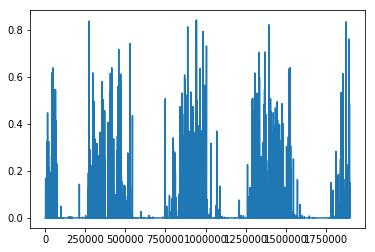

In [4]:
bin_mid = np.concatenate([np.array([0]), (dsd_ds['bin_edges'].values[1:] + dsd_ds['bin_edges'].values[:-1])/2.0])
print(bin_mid)
bin_dD = 0.1
Nd = dsd_ds['num_drop'].values
lwc = np.zeros(len(dsd_ds.time))
for i in range(len(lwc)):
    lwc[i] = np.sum(Nd[i]*bin_mid**3*1e-3*bin_dD*1e-1)
plt.plot(lwc)
num_drops = np.sum(dsd_ds['num_drop'].values, axis=1)

In [5]:
dsd_ds.time.values[-1]

numpy.datetime64('2015-01-03T23:59:00.000000000')

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


[371.12664013   0.94394896]


NameError: name 'ax2' is not defined

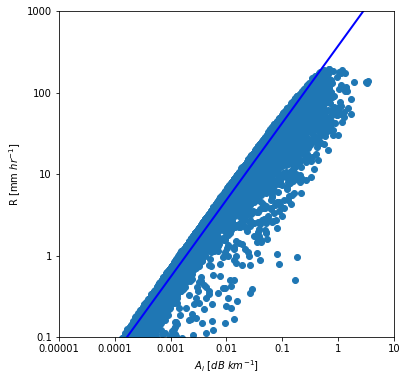

In [6]:
# Fit 
fitfunc = lambda p, x: np.log10(p[0]) + p[1]*np.log10(x) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - np.log10(y) # Distance to the target function

p0 = [100, 0.9] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['Ai'].values > 1e-5, dsd_ds['rain_rate'].values > 0.05,
                             num_drops > 100,
                             ))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(dsd_ds['Ai'].values[gt0], dsd_ds['rain_rate'].values[gt0]))
print(p1)

wang_et_al_2014 = [359, 0.88]
thompson_et_al_2015 = [447.37, 0.93]
x_range = np.linspace(-4, 3, 30)
y_range = np.linspace(-1, 3, 30)
hist, x, y = np.histogram2d(np.log10(dsd_ds['Ai'].values[gt0]), 
                                     np.log10(dsd_ds['rain_rate'].values[gt0]), bins=(x_range, y_range)) 

fig, ax = plt.subplots(1, figsize=(6,6))
hist = np.ma.masked_where(hist ==0, hist)
#mesh = ax.pcolormesh(x,y,np.log10(hist.T), cmap='coolwarm')
ax.scatter(np.log10(dsd_ds['Ai'].values[gt0]), np.log10(dsd_ds['rain_rate'].values[gt0]))
ax.plot(x_range, fitfunc(p1, 10**x_range), color='b', linewidth='2')
#ax.plot(x_range, fitfunc(wang_et_al_2014, 10**x_range), color='r', linewidth='2')
#ax.plot(x_range, fitfunc(thompson_et_al_2015, 10**x_range), color='g', linewidth='2')
ax.set_xlim([-4, 1])
ax.set_ylim([-1, 3])
ax.set_xticklabels(['0.00001', '0.0001', '0.001', '0.01', '0.1', '1', '10'])
ax.set_xticks([-5,-4,-3,-2,-1,0,1])
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(['0.1', '1', '10', '100', '1000'])
ax.set_ylabel('R [mm $hr^{-1}$]')
ax.set_xlabel('$A_{i}$ [$dB\ km^{-1}$]')
#ax2 = plt.colorbar(mesh, ax=ax)
ax2.set_ticks([0,1,2,3])
ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend([('R = ' + "%4.2f" % p1[0] + '$A_{r}^{' + "%4.2f" % p1[1] + '}$'),
           ], loc='best')
plt.title('VDIS R vs $A_{r}$')

In [ ]:
# Fit 
fitfunc = lambda p, x: np.log10(p[0]) + p[1]*np.log10(x) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - np.log10(y) # Distance to the target function

p0 = [0.063, 0.68] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['Zh'].values > 0, dsd_ds['rain_rate'].values > 0.05, num_drops > 100,
                     dsd_ds.time.values >= np.datetime64('2011-02-28T00:01:00.000000000'),
                     np.logical_and(dsd_ds['mjo_index'].values >= 3,
                             dsd_ds['mjo_index'].values < 8),
                     dsd_ds.time.values <= np.datetime64('2015-01-03T23:59:00.000000000')))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(10**(dsd_ds['Zh'].values[gt0]/10), dsd_ds['rain_rate'].values[gt0]))
print(p1)

wang_et_al_2014 = [359, 0.88]
thompson_et_al_2015 = [447.37, 0.93]
y_range = np.linspace(-2, 3, 30)
x_range = np.linspace(0, 70, 30)
hist, x, y = np.histogram2d(dsd_ds['Zh'].values[gt0], 
                                     np.log10(dsd_ds['rain_rate'].values[gt0]), bins=(x_range, y_range)) 

fig, ax = plt.subplots(1, figsize=(6,6))
hist = np.ma.masked_where(hist ==0, hist)
#mesh = ax.pcolormesh(x,y,np.log10(hist.T), cmap='coolwarm')
ax.scatter(dsd_ds['Zh'].values[gt0], np.log10(dsd_ds['rain_rate'].values[gt0]))
ax.plot(x_range, fitfunc(p1, 10**(x_range/10)), color='b', linewidth='2')
#ax.plot(x_range, fitfunc(wang_et_al_2014, 10**x_range), color='r', linewidth='2')
#ax.plot(x_range, fitfunc(thompson_et_al_2015, 10**x_range), color='g', linewidth='2')
ax.set_xlim([0, 70])
ax.set_ylim([-1, 3])
#ax.set_xticklabels(['0.00001', '0.0001', '0.001', '0.01', '0.1', '1', '10'])
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(['0.1', '1', '10', '100', '1000'])
ax.set_ylabel('R [mm $hr^{-1}$]')
ax.set_xlabel('$Z_{h}}$ [dBZ]')
ax2.set_ticks([0,1,2,3])
ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend([('R = ' + "%5.4f" % p1[0] + '$Z_{h}^{' + "%4.2f" % p1[1] + '}$'),
           ], loc='best')
plt.title('VDIS R vs $Z_{h}$')

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


[26.04919868  0.76433495]


Text(0.5,1,'VDIS R vs $K_{dp}$')

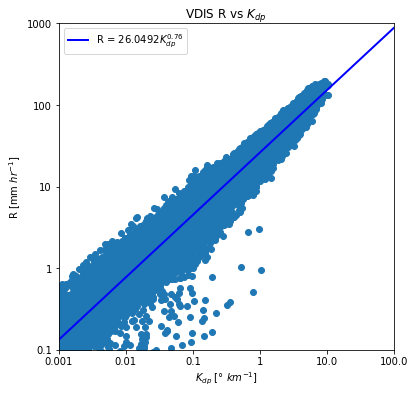

In [18]:
# Fit 
fitfunc = lambda p, x: np.log10(p[0]) + p[1]*np.log10(x) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - np.log10(y) # Distance to the target function

p0 = [0.063, 0.68] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['Kdp'].values > 0, dsd_ds['rain_rate'].values > 0.05, num_drops > 100,
                     dsd_ds.time.values >= np.datetime64('2011-02-28T00:01:00.000000000'),
                     dsd_ds.time.values <= np.datetime64('2015-01-03T23:59:00.000000000')))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(dsd_ds['Kdp'].values[gt0], dsd_ds['rain_rate'].values[gt0]))
print(p1)

wang_et_al_2014 = [359, 0.88]
thompson_et_al_2015 = [447.37, 0.93]
y_range = np.linspace(-2, 3, 30)
x_range = np.linspace(-3, 2, 30)
hist, x, y = np.histogram2d(np.log10(dsd_ds['Kdp'].values[gt0]), 
                                     np.log10(dsd_ds['rain_rate'].values[gt0]), bins=(x_range, y_range)) 

fig, ax = plt.subplots(1, figsize=(6,6))
hist = np.ma.masked_where(hist ==0, hist)
#mesh = ax.pcolormesh(x,y,np.log10(hist.T), cmap='coolwarm')
ax.scatter(np.log10(dsd_ds['Kdp'].values[gt0]), np.log10(dsd_ds['rain_rate'].values[gt0]))
ax.plot(x_range, fitfunc(p1, 10**(x_range)), color='b', linewidth='2')
#ax.plot(x_range, fitfunc(wang_et_al_2014, 10**x_range), color='r', linewidth='2')
#ax.plot(x_range, fitfunc(thompson_et_al_2015, 10**x_range), color='g', linewidth='2')
ax.set_xlim([-3, 2])
ax.set_ylim([-1, 3])
#ax.set_xticklabels(['0.00001', '0.0001', '0.001', '0.01', '0.1', '1', '10'])
ax.set_yticks([-1,0,1,2,3])
ax.set_xticks([-3, -2, -1, 0, 1, 2])
ax.set_xticklabels(['0.001', '0.01', '0.1', '1', '10.0', '100.0'])
ax.set_yticklabels(['0.1', '1', '10', '100', '1000'])
ax.set_ylabel('R [mm $hr^{-1}$]')
ax.set_xlabel('$K_{dp}$ [$\degree \ km^{-1}$]')
ax2.set_ticks([0,1,2,3])
ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend([('R = ' + "%5.4f" % p1[0] + '$K_{dp}^{' + "%4.2f" % p1[1] + '}$'),
           ], loc='best')
plt.title('VDIS R vs $K_{dp}$')

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: Ru

[ 0.01232894  0.84898267 -4.14151232]


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


Text(0.5,1,'R = 0.0123$Z_{h}^{0.85}$$Z_{dr}^{-4.14}$')

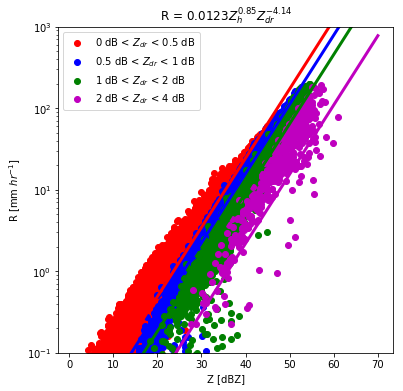

In [20]:
# Fit 
fitfunc = lambda p, x1, x2: np.log10(p[0]) + p[1]*np.log10(x1) + p[2]*np.log10(x2) # Target function
errfunc = lambda p, x1, x2, y: fitfunc(p, x1, x2) - np.log10(y) # Distance to the target function

p0 = [0.063, 0.68, 1.00] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['rain_rate'].values > 0.05, dsd_ds['Kdp'].values > 0, num_drops > 100))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(10**(dsd_ds['Zh'].values[gt0]/10),
                                                     10**(dsd_ds['Zdr'].values[gt0]/10),
                                                     dsd_ds['rain_rate'].values[gt0]))
print(p1)
keenan_et_al_2001 = [0.00870, 0.91, -4.94]
wang_et_al_2014 = [359, 0.88]
thompson_et_al_2015 = [447.37, 0.93]
x_range = np.linspace(10, 70, 100)
gt0_zdr_0_05 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 0, dsd_ds['Zdr'].values < 0.5))
gt0_zdr_05_1 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 0.5, dsd_ds['Zdr'].values < 1))
gt0_zdr_1_2 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 1, dsd_ds['Zdr'].values < 2))
gt0_zdr_2_4 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 2, dsd_ds['Zdr'].values < 4))
fig, ax = plt.subplots(1, figsize=(6,6))
ax.scatter(dsd_ds['Zh'].values[gt0_zdr_0_05], dsd_ds['rain_rate'].values[gt0_zdr_0_05], color='r', label='0 dB < $Z_{dr}$ < 0.5 dB')
ax.scatter(dsd_ds['Zh'].values[gt0_zdr_05_1], dsd_ds['rain_rate'].values[gt0_zdr_05_1], color='b', label='0.5 dB < $Z_{dr}$ < 1 dB')
ax.scatter(dsd_ds['Zh'].values[gt0_zdr_1_2], dsd_ds['rain_rate'].values[gt0_zdr_1_2], color='g', label='1 dB < $Z_{dr}$ < 2 dB')
ax.scatter(dsd_ds['Zh'].values[gt0_zdr_2_4], dsd_ds['rain_rate'].values[gt0_zdr_2_4], color='m', label='2 dB < $Z_{dr}$ < 4 dB')
ax.plot(x_range, 10**fitfunc(p1, 10**(x_range/10), 10**(dsd_ds['Zdr'].values[gt0_zdr_0_05].mean()/10)), color='r', linewidth=3)
ax.plot(x_range, 10**fitfunc(p1, 10**(x_range/10), 10**(dsd_ds['Zdr'].values[gt0_zdr_05_1].mean()/10)), color='b', linewidth=3)
ax.plot(x_range, 10**fitfunc(p1, 10**(x_range/10), 10**(dsd_ds['Zdr'].values[gt0_zdr_1_2].mean()/10)), color='g', linewidth=3)
ax.plot(x_range, 10**fitfunc(p1, 10**(x_range/10), 10**(dsd_ds['Zdr'].values[gt0_zdr_2_4].mean()/10)), color='m', linewidth=3)
ax.set_xlabel('Z [dBZ]')
ax.set_ylabel('R [mm $hr^{-1}$]')
ax.set_yscale('log')
ax.set_ylim([0.1, 1000])
ax2.set_ticks([0,1,2,3])
ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend(loc='best')
plt.title(('R = ' + "%5.4f" % p1[0] + '$Z_{h}^{' + "%4.2f" % p1[1] + '}$' + '$Z_{dr}^{' + "%4.2f" % p1[2] + '}$'),
           )
#plt.title('VDIS R vs $K_{dp}$')

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipy

[46.23472887  0.90211055 -1.68850309]


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'R = 46.2347$K_{dp}^{0.90}$$Z_{dr}^{-1.69}$')

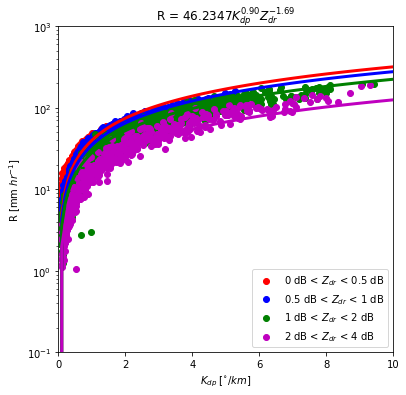

In [16]:
# Fit 
fitfunc = lambda p, x1, x2: np.log10(p[0]) + p[1]*np.log10(x1) + p[2]*np.log10(x2) # Target function
errfunc = lambda p, x1, x2, y: fitfunc(p, x1, x2) - np.log10(y) # Distance to the target function

p0 = [0.063, 0.68, 1.00] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['rain_rate'].values > 1, dsd_ds['Kdp'].values > 0.1, num_drops > 100))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(dsd_ds['Kdp'].values[gt0],
                                                     10**(dsd_ds['Zdr'].values[gt0]/10),
                                                     dsd_ds['rain_rate'].values[gt0]))
print(p1)
keenan_et_al_2001 = [0.00870, 0.91, -4.94]
wang_et_al_2014 = [359, 0.88]
thompson_et_al_2015 = [447.37, 0.93]
x_range = np.linspace(0, 10, 100)
gt0_zdr_0_05 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 0, dsd_ds['Zdr'].values < 0.5))
gt0_zdr_05_1 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 0.5, dsd_ds['Zdr'].values < 1))
gt0_zdr_1_2 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 1, dsd_ds['Zdr'].values < 2))
gt0_zdr_2_4 = np.logical_and.reduce((gt0, dsd_ds['Zdr'].values > 2, dsd_ds['Zdr'].values < 4))
fig, ax = plt.subplots(1, figsize=(6,6))
ax.scatter(dsd_ds['Kdp'].values[gt0_zdr_0_05], dsd_ds['rain_rate'].values[gt0_zdr_0_05], color='r', label='0 dB < $Z_{dr}$ < 0.5 dB')
ax.scatter(dsd_ds['Kdp'].values[gt0_zdr_05_1], dsd_ds['rain_rate'].values[gt0_zdr_05_1], color='b', label='0.5 dB < $Z_{dr}$ < 1 dB')
ax.scatter(dsd_ds['Kdp'].values[gt0_zdr_1_2], dsd_ds['rain_rate'].values[gt0_zdr_1_2], color='g', label='1 dB < $Z_{dr}$ < 2 dB')
ax.scatter(dsd_ds['Kdp'].values[gt0_zdr_2_4], dsd_ds['rain_rate'].values[gt0_zdr_2_4], color='m', label='2 dB < $Z_{dr}$ < 4 dB')
ax.plot(x_range, 10**fitfunc(p1, x_range, 10**(dsd_ds['Zdr'].values[gt0_zdr_0_05].mean()/10)), color='r', linewidth=3)
ax.plot(x_range, 10**fitfunc(p1, x_range, 10**(dsd_ds['Zdr'].values[gt0_zdr_05_1].mean()/10)), color='b', linewidth=3)
ax.plot(x_range, 10**fitfunc(p1, x_range, 10**(dsd_ds['Zdr'].values[gt0_zdr_1_2].mean()/10)), color='g', linewidth=3)
ax.plot(x_range, 10**fitfunc(p1, x_range, 10**(dsd_ds['Zdr'].values[gt0_zdr_2_4].mean()/10)), color='m', linewidth=3)
ax.set_xlabel('$K_{dp}$ [$^{\circ}/km$]')
ax.set_ylabel('R [mm $hr^{-1}$]')
ax.set_yscale('log')
ax.set_ylim([0.1, 1000])
ax.set_xlim([0, 10])
#ax2.set_ticks([0,1,2,3])
#ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend(loc='best')
plt.title(('R = ' + "%5.4f" % p1[0] + '$K_{dp}^{' + "%4.2f" % p1[1] + '}$' + '$Z_{dr}^{' + "%4.2f" % p1[2] + '}$'),
           )
#plt.title('VDIS R vs $K_{dp}$')

nan
0.07921982686266764


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


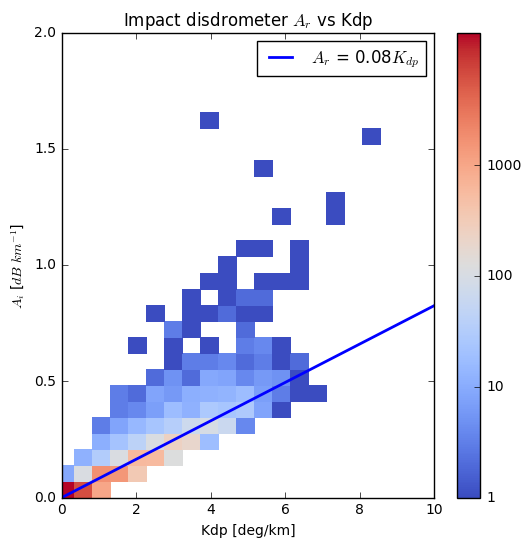

In [47]:
# Fit 
fitfunc = lambda p, x: p[0]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
print(dsd_ds['Ai'].values.max())
p0 = [0.01] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['Ai'].values > 1e-4, dsd_ds['rain_rate'].values > 0.5,
                             num_drops > 20, dsd_ds['Ai'].values < 2, dsd_ds['Kdp'].values > 0.1,
                             ))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(dsd_ds['Kdp'].values[gt0], dsd_ds['Ai'].values[gt0]))
alpha = dsd_ds['Ai'].values[gt0]/dsd_ds['Kdp'].values[gt0]
print(alpha.mean())

wang_et_al_2014 = [359, 0.88]
thompson_et_al_2015 = [447.37, 0.93]
x_range = np.linspace(-4, 10, 30)
y_range = np.linspace(0, 2, 30)
hist, x, y = np.histogram2d(dsd_ds['Kdp'].values[gt0], dsd_ds['Ai'].values[gt0], bins=(x_range, y_range)) 

fig, ax = plt.subplots(1, figsize=(6,6))
hist = np.ma.masked_where(hist ==0, hist)
mesh = ax.pcolormesh(x,y,np.log10(hist.T), cmap='coolwarm')
ax.plot(x_range, fitfunc(p1, x_range), color='b', linewidth='2')
ax.set_xlim([0, 10])
ax.set_ylim([0, 2])
ax.set_xlabel('Kdp [deg/km]')
ax.set_ylabel('$A_{i}$ [$dB\ km^{-1}$]')
ax2 = plt.colorbar(mesh, ax=ax)
ax2.set_ticks([0,1,2,3])
ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend([('$A_{r}$ = ' + "%4.2f" % p1[0] + '$K_{dp}$'),
           'Wang et al. (2014)', 'Thompson et al. (2015)'], loc='best')
plt.title('Impact disdrometer $A_{r}$ vs Kdp')

[0.01808623]


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


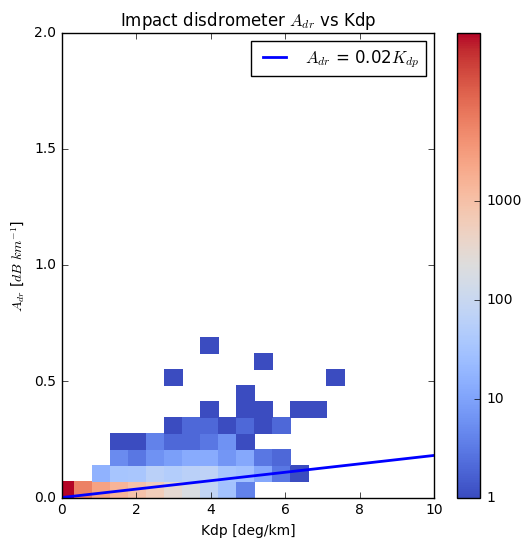

In [54]:
# Fit 
fitfunc = lambda p, x: p[0]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

p0 = [0.01] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['Adr'].values > 1e-4, dsd_ds['rain_rate'].values > 0.5,
                             num_drops > 20,  dsd_ds['Ai'].values < 2,
                             ))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(dsd_ds['Kdp'].values[gt0], dsd_ds['Adr'].values[gt0]))
print(p1)

wang_et_al_2014 = [359, 0.88]
thompson_et_al_2015 = [447.37, 0.93]
x_range = np.linspace(-4, 10, 30)
y_range = np.linspace(0, 2, 30)
hist, x, y = np.histogram2d(dsd_ds['Kdp'].values[gt0], dsd_ds['Adr'].values[gt0], bins=(x_range, y_range)) 

fig, ax = plt.subplots(1, figsize=(6,6))
hist = np.ma.masked_where(hist ==0, hist)
mesh = ax.pcolormesh(x,y,np.log10(hist.T), cmap='coolwarm')
ax.plot(x_range, fitfunc(p1, x_range), color='b', linewidth='2')
ax.set_xlim([0, 10])
ax.set_ylim([0, 2])
ax.set_xlabel('Kdp [deg/km]')
ax.set_ylabel('$A_{dr}$ [$dB\ km^{-1}$]')
ax2 = plt.colorbar(mesh, ax=ax)
ax2.set_ticks([0,1,2,3])
ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend([('$A_{dr}$ = ' + "%4.2f" % p1[0] + '$K_{dp}$'),
           'Wang et al. (2014)', 'Thompson et al. (2015)'], loc='best')
plt.title('Impact disdrometer $A_{dr}$ vs Kdp')

## Probablistic QPEs

[281.34067588   0.88132316]


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


Text(0.5,1,'VDIS R vs $A_{r}$')

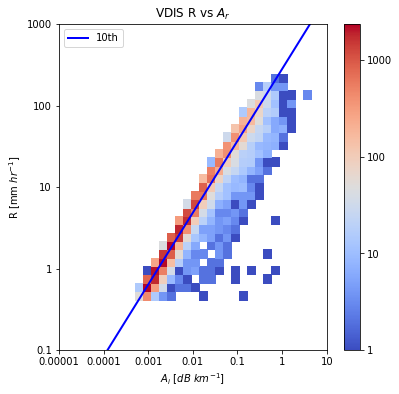

In [16]:
# Fit 
fitfunc = lambda p, x: np.log10(p[0]) + p[1]*np.log10(x) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - np.log10(y) # Distance to the target function

p0 = [100, 0.9] # Initial guess for the parameters
gt0 = np.logical_and.reduce((dsd_ds['Ai'].values > 1e-4, dsd_ds['rain_rate'].values > 0.5,
                             num_drops > 20,
                             ))       
p1, success = optimize.leastsq(errfunc, p0[:], args=(dsd_ds['Ai'].values[gt0], dsd_ds['rain_rate'].values[gt0]))
print(p1)

x_range = np.linspace(-4, 3, 40)
y_range = np.linspace(-1, 3, 40)
hist, x, y = np.histogram2d(np.log10(dsd_ds['Ai'].values[gt0]), 
                                     np.log10(dsd_ds['rain_rate'].values[gt0]), bins=(x_range, y_range)) 

fig, ax = plt.subplots(1, figsize=(6,6))
hist = np.ma.masked_where(hist == 0, hist)
mesh = ax.pcolormesh(x,y,np.log10(hist.T), cmap='coolwarm')
ax.plot(x_range, fitfunc(p1, 10**x_range), color='b', linewidth='2')
ax.set_xlim([-4, 1])
ax.set_ylim([-1, 3])
ax.set_xticklabels(['0.00001', '0.0001', '0.001', '0.01', '0.1', '1', '10'])
ax.set_xticks([-5,-4,-3,-2,-1,0,1])
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(['0.1', '1', '10', '100', '1000'])
ax.set_ylabel('R [mm $hr^{-1}$]')
ax.set_xlabel('$A_{i}$ [$dB\ km^{-1}$]')
ax2 = plt.colorbar(mesh, ax=ax)
ax2.set_ticks([0,1,2,3])
ax2.set_ticklabels(['1', '10', '100', '1000'])
plt.legend(['10th', '25th', '50th', '75th', '90th'], loc='best')
plt.title('VDIS R vs $A_{r}$')

## Test Gaussian PDE vs Lognormal PDE

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


1.1030205
(0.0005741644093418359, -245.7497859342858, 246.85217815654642)


(0, 10)

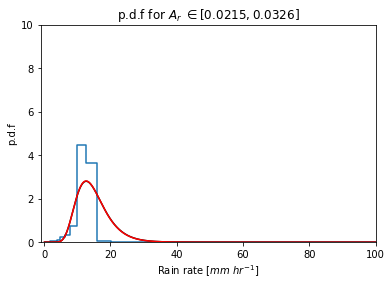

In [17]:
which_hist = 13
x_range = np.linspace(-4, 3, 40)
y_range = np.linspace(-1, 3, 40)
y_bins = (y_range[1:]+y_range[:-1])/2
hist_w_zeros = np.ma.filled(hist, 0)
in_range = np.logical_and.reduce((gt0, np.log10(dsd_ds['Ai'].values) >= x_range[which_hist],
                                               np.log10(dsd_ds['Ai'].values) < x_range[which_hist+1]))
loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

sigma_first = np.std(np.log10(dsd_ds['rain_rate'].values[in_range]))
the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
the_fit_lognorm = stats.lognorm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), sigma_first, loc=loc_first)
hist_w_zeros, bins = np.histogram(np.log10(dsd_ds['rain_rate'].values[in_range]), bins=y_range)
y_bins = (bins[1:]+bins[:-1])/2
print(loc_first)
print(the_fit_lognorm)
plt.step(10**y_bins, hist_w_zeros/np.sum(hist_w_zeros)/np.diff(bins))
plt.plot(10**np.linspace(-1,4,1000), 
         stats.norm.pdf(np.linspace(-1,4,1000), the_fit[0], the_fit[1]), color='k', label='Normal')
plt.plot(10**np.linspace(-1,4,1000), 
         stats.lognorm.pdf(np.linspace(-1,4,1000), the_fit_lognorm[0], the_fit_lognorm[1], the_fit_lognorm[2]), 
         color='r', label='Lognormal')
plt.xlabel('Rain rate [$mm \ hr^{-1}$]')
plt.ylabel('p.d.f')
plt.title('p.d.f for $A_{r} \ \in [' + "%5.4f" % 10**x_range[which_hist] + ',' + "%5.4f" % 10**x_range[which_hist+1] + ']$')
plt.xlim([-1,100])
plt.ylim([0,10])

-0.23269333
(0.9261560516293326, -0.30773383299556234, 0.05115431437970901)


(0, 10)

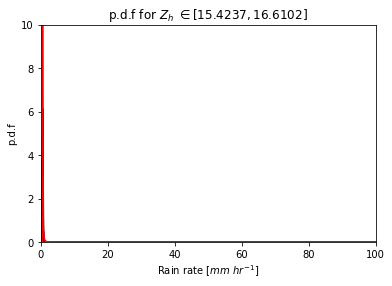

In [18]:
y_range = np.linspace(-2, 3, 30)
x_range = np.linspace(0, 70, 60)
which_hist = 13
y_bins = (y_range[1:]+y_range[:-1])/2
hist_w_zeros = np.ma.filled(hist, 0)
in_range = np.logical_and.reduce((gt0, dsd_ds['Zh'].values >= x_range[which_hist],
                                               dsd_ds['Zh'].values < x_range[which_hist+1]))
loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

sigma_first = np.std(np.log10(dsd_ds['rain_rate'].values[in_range]))
the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
the_fit_lognorm = stats.lognorm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), sigma_first, loc=loc_first)
hist_w_zeros, bins = np.histogram(np.log10(dsd_ds['rain_rate'].values[in_range]), bins=y_range)
y_bins = (bins[1:]+bins[:-1])/2
print(loc_first)
print(the_fit_lognorm)
plt.step(10**y_bins, hist_w_zeros/np.sum(hist_w_zeros)/np.diff(bins))
plt.plot(10**np.linspace(-1,4,1000), 
         stats.norm.pdf(np.linspace(-1,4,1000), the_fit[0], the_fit[1]), color='k', label='Normal')
plt.plot(10**np.linspace(-1,4,1000), 
         stats.lognorm.pdf(np.linspace(-1,4,1000), the_fit_lognorm[0], the_fit_lognorm[1], the_fit_lognorm[2]), 
         color='r', label='Lognormal')
plt.xlabel('Rain rate [$mm \ hr^{-1}$]')
plt.ylabel('p.d.f')
plt.title('p.d.f for $Z_{h} \ \in [' + "%5.4f" % x_range[which_hist] + ',' + "%5.4f" % x_range[which_hist+1] + ']$')
plt.xlim([0,100])
plt.ylim([0,10])

## Make probabilistic method for calculating rain rate from Z

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


-0.80482084 0.15625498
-0.77747816 0.16978386
-0.74502903 0.16428682
-0.708154 0.16839623
-0.6715505 0.16310607
-0.63461804 0.17768835
-0.6065111 0.16954355
-0.57904506 0.17742166
-0.53564113 0.17946938
-0.50139564 0.17856203
-0.47736493 0.18361531
-0.44518247 0.1802592
-0.40449515 0.18537125
-0.37679055 0.18359388
-0.33893555 0.19399345
-0.30422002 0.18410058
-0.27214444 0.19717595
-0.22273342 0.19522525
-0.19948801 0.19997759
-0.15768433 0.20231
-0.13488507 0.19690178
-0.09197413 0.2040336
-0.06543497 0.20269424
-0.02829822 0.20682767
0.012759747 0.1996239
0.051635727 0.20705968
0.08670224 0.21343127
0.1364387 0.19844544
0.16772473 0.20055656
0.21332306 0.20032004
0.2265716 0.2053556
0.28369468 0.20166084
0.32443616 0.18928559
0.36423376 0.19356297
0.39225397 0.21002477
0.42619723 0.2009258
0.47633553 0.20601027
0.50553864 0.18987344
0.56251884 0.18888205
0.6019898 0.1954177
0.608604 0.19824539
0.6556772 0.19654113
0.697779 0.19002916
0.7290483 0.21260388
0.77561194 0.2040701
0.82940

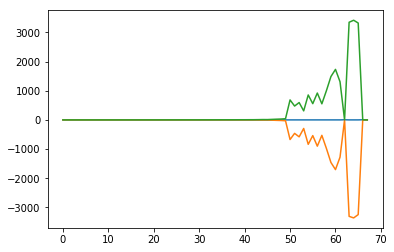

In [19]:
x_range = np.concatenate([np.arange(13, 45, 0.5), np.arange(47, 55, 2)])
the_fit = np.zeros((len(x_range),3))
gt0 = np.logical_and.reduce((dsd_ds['rain_rate'].values > 0.05, num_drops > 100))       
for i in range(len(x_range)-1):
    which_hist = i
    y_bins = (y_range[1:]+y_range[:-1])/2
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, dsd_ds['Zh'].values >= x_range[which_hist],
                                           dsd_ds['Zh'].values < x_range[which_hist+1]))

    loc_first = np.nanmean(np.log10(dsd_ds['rain_rate'].values[in_range]))

    sigma_first = np.nanstd(np.log10(dsd_ds['rain_rate'].values[in_range]))
    print(loc_first, sigma_first)
    #try:
    if(not np.isnan(sigma_first)):
        the_fit[i] = stats.lognorm.fit(dsd_ds['rain_rate'].values[in_range], loc=loc_first, scale=sigma_first)
    #except:
    #    print("I wanna be with you,make believe with you, and live in harmony harmony always")                                
plt.plot(the_fit)
the_fit_reflectivity = open('the_fit_refl.pickle', 'wb')
the_fit_dic = {'the_fit': the_fit, 'x_range': x_range}
pickle.dump(the_fit_dic, the_fit_reflectivity)
the_fit_reflectivity.close()

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


-0.6322089 0.34390095
-0.04131788 0.18542658
0.15623999 0.16894847
0.27619457 0.16274214
0.36801666 0.16411878
0.4423397 0.16291279
0.49157915 0.1631207
0.5591209 0.15179858
0.5880707 0.15552716
0.6271416 0.17506991
0.67088664 0.1557315
0.70406914 0.14543799
0.73248917 0.14325477
0.75972855 0.15374902
0.7811239 0.19776659
0.8137077 0.17078543
0.8417526 0.14238885
0.85665077 0.15061104
0.8824737 0.14472641
0.8995563 0.19257475
0.95110315 0.13983975
0.9089439 0.19375701
0.96904886 0.13677584
0.99784666 0.13367541
0.99469125 0.13923258
0.9948403 0.1655376
1.0517001 0.12746854
1.0291926 0.161429
1.0474396 0.15147324
1.0411639 0.15514329
1.097729 0.13969775
1.0803653 0.14522175
1.0920893 0.18014343
1.0935137 0.13199037
1.1188725 0.14151186
1.1215563 0.15652706
1.1075841 0.2283463
1.1331297 0.13884939
1.1701288 0.11484078
1.1722655 0.1424403
1.1380987 0.17254916
1.1788789 0.13477863
1.1960744 0.13108952
1.1384997 0.15779252
1.2325832 0.11540529
1.1936293 0.14161627
1.2475567 0.10610648
1.243

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


nan nan
2.0585997 0.07819136
2.0627725 0.053191796
2.1244364 0.009741806
2.0879405 0.06974673
2.1886148 0.055519886
nan nan
2.167954 0.0601272
2.2384963 0.0
2.141066 0.06986189
2.148467 0.0


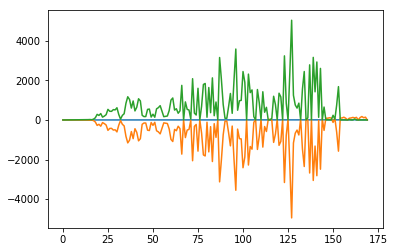

In [56]:
x_range = np.concatenate([np.arange(0, 1, 0.01), np.arange(1,8,0.1)])
the_fit = np.zeros((len(x_range),3))
gt0 = np.logical_and.reduce((dsd_ds['rain_rate'].values > 0.05, num_drops > 100))       
for i in range(len(x_range)-1):
    which_hist = i
    y_bins = (y_range[1:]+y_range[:-1])/2
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, dsd_ds['Kdp'].values >= x_range[which_hist],
                                           dsd_ds['Kdp'].values < x_range[which_hist+1]))

    loc_first = np.nanmean(np.log10(dsd_ds['rain_rate'].values[in_range]))

    sigma_first = np.nanstd(np.log10(dsd_ds['rain_rate'].values[in_range]))
    print(loc_first, sigma_first)
    #try:
    if(not np.isnan(sigma_first)):
        the_fit[i] = stats.lognorm.fit(dsd_ds['rain_rate'].values[in_range], loc=loc_first, scale=sigma_first)
    #except:
    #    print("I wanna be with you,make believe with you, and live in harmony harmony always")                                
plt.plot(the_fit)
the_fit_kdp = open('the_fit_kdp.pickle', 'wb')
the_fit_dic = {'the_fit': the_fit, 'x_range': x_range}
pickle.dump(the_fit_dic, the_fit_kdp)
the_fit_kdp.close()

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


-0.22698788 0.07651405
-0.20196594 0.074959695
-0.1728314 0.09216011
-0.13919841 0.07920014
-0.11006878 0.08254263
-0.08474767 0.084685355
-0.04788846 0.07307079
-0.024189025 0.06582472
0.007911886 0.06890295
0.035708766 0.06604698
0.06703904 0.063507706
0.09654604 0.08055218
0.122287005 0.07710714
0.15732819 0.07501629
0.18989119 0.054590844
0.21449448 0.07471372
0.24265295 0.077020906
0.27944955 0.05655975
0.2979092 0.07497991
0.33465537 0.06923877
0.36137426 0.08658633
0.39394748 0.055434197
0.41869435 0.08039954
0.4504197 0.065280356
0.46826255 0.10570991
0.50406903 0.067461014
0.5389182 0.05586124
0.55971736 0.06717796
0.58944225 0.084009506
0.62030226 0.06699633
0.6476205 0.06447681
0.6730236 0.08579389
0.69158554 0.13212408
0.7297555 0.09152883
0.7636407 0.08585562
0.78504646 0.11417796
0.82089627 0.093486026
0.8349571 0.14599332
0.87398165 0.11037173
0.90552974 0.111544244
0.93622273 0.09693886
0.96305925 0.100667164
0.9905786 0.114166364
1.021791 0.0882258
1.0401369 0.12374364

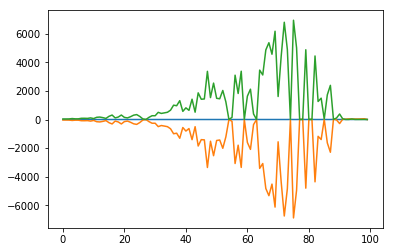

In [55]:
x_range = np.logspace(-3, 0, 100)
the_fit = np.zeros((len(x_range),3))
gt0 = np.logical_and.reduce((dsd_ds['rain_rate'].values > 0.05, num_drops > 100))       
for i in range(len(x_range)-1):
    which_hist = i
    y_bins = (y_range[1:]+y_range[:-1])/2
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, dsd_ds['Ai'].values >= x_range[which_hist],
                                           dsd_ds['Ai'].values < x_range[which_hist+1]))

    loc_first = np.nanmean(np.log10(dsd_ds['rain_rate'].values[in_range]))

    sigma_first = np.nanstd(np.log10(dsd_ds['rain_rate'].values[in_range]))
    print(loc_first, sigma_first)
    #try:
    if(not np.isnan(sigma_first)):
        the_fit[i] = stats.lognorm.fit(dsd_ds['rain_rate'].values[in_range], loc=loc_first, scale=sigma_first)
    #except:
    #    print("I wanna be with you,make believe with you, and live in harmony harmony always")                                
plt.plot(the_fit)
the_fit_ar = open('the_fit_ar.pickle', 'wb')
the_fit_dic = {'the_fit': the_fit, 'x_range': x_range}
pickle.dump(the_fit_dic, the_fit_ar)
the_fit_ar.close()

## Uncertainty vs Z, A_r, Kdp - Pierre Kirschetter

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


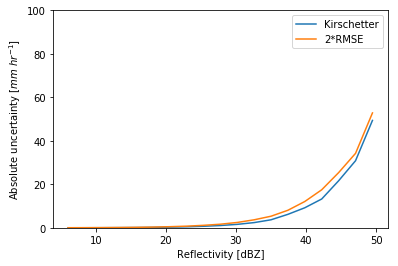

In [20]:
x_range = np.linspace(0, 70, 30)
y_range = np.linspace(-1, 3, 40)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
uncertainty_z_darwin = np.zeros(len(x_range)-1)
rmse = np.zeros(len(x_range)-1)

for which_hist in range(len(x_range)-1):
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, dsd_ds['Zh'].values >= x_range[which_hist],
                                      dsd_ds['Zh'].values < x_range[which_hist+1]))
    loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))
    #0.0192*(10**(ds['Z_dis']/10))**0.71
    the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    if(len(np.where(in_range)[0]) > 500):
        uncertainty_z_darwin[which_hist] = (10**quartiles[1]-10**quartiles[0])
        rmse[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                              0.0192*(10**(dsd_ds['Zh'].values[in_range]/10))**0.71))
    else:
        uncertainty_z_darwin[which_hist] = np.nan
        rmse[which_hist] = np.nan
plt.plot(x_bins, uncertainty_z_darwin)
plt.plot(x_bins, rmse)
plt.ylabel('Absolute uncertainty [$mm\ hr^{-1}$]')
plt.xlabel('Reflectivity [dBZ]')
plt.ylim([0, 100])
plt.legend(['Kirschetter', '2*RMSE'])

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_dis

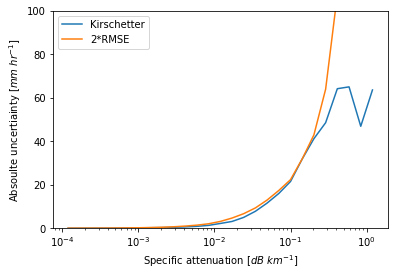

In [21]:
x_range = np.linspace(-4, 2, 40)
y_range = np.linspace(-1, 3, 40)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
uncertainty_ar_darwin = np.zeros(len(x_range)-1)
rmse = np.zeros(len(x_range)-1)
mean_rr_ar_darwin = np.zeros_like(rmse)

fig, ax = plt.subplots(1,1)
for which_hist in range(len(x_range)-1):
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, np.log10(dsd_ds['Ai'].values) >= x_range[which_hist],
                                      np.log10(dsd_ds['Ai'].values) < x_range[which_hist+1]))
    loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

    the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #297.87*(ds['Ar_dis'])**0.92
    if(len(np.where(in_range)[0]) > 5):
        uncertainty_ar_darwin[which_hist] = (10**quartiles[1]-10**quartiles[0])
        rmse[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                              297.87*((dsd_ds['Ai'].values[in_range]))**0.92))
        mean_rr_ar_darwin[which_hist] = 10**loc_first
    else:
        uncertainty_ar_darwin[which_hist] = np.nan
        rmse[which_hist] = np.nan
        mean_rr_ar_darwin[which_hist] = np.nan

ax.plot(10**x_bins, uncertainty_ar_darwin)
ax.plot(10**x_bins, rmse)
ax.set_xlabel('Specific attenuation [$dB\ km^{-1}$]')
ax.set_ylabel('Absoulte uncertiainty [$mm\ hr^{-1}$]')
ax.set_xscale('log')
ax.set_ylim([0,100])
ax.legend(['Kirschetter', '2*RMSE'])

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/env

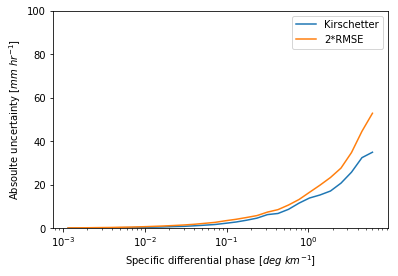

In [22]:
x_range = np.linspace(-3, 2, 40)
y_range = np.linspace(-1, 3, 40)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
uncertainty_kdp_darwin = np.zeros(len(x_range)-1)
mean_rr_kdp_darwin = np.zeros_like(uncertainty_kdp_darwin)
rmse = np.zeros(len(x_range)-1)
fig, ax = plt.subplots(1,1)
for which_hist in range(len(x_range)-1):
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, np.log10(dsd_ds['Kdp'].values) >= x_range[which_hist],
                                      np.log10(dsd_ds['Kdp'].values) < x_range[which_hist+1]))
    loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

    the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #31.1840*ds['kdp_dis']**0.77
    if(len(np.where(in_range)[0]) > 50):
        uncertainty_kdp_darwin[which_hist] = (10**quartiles[1]-10**quartiles[0])
        mean_rr_kdp_darwin[which_hist] = 10**loc_first
        rmse[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                              31.1840*((dsd_ds['Kdp'].values[in_range]))**0.77))
    else:
        uncertainty_kdp_darwin[which_hist] = np.nan
        mean_rr_kdp_darwin[which_hist] = np.nan
        rmse[which_hist] = np.nan



ax.plot(10**x_bins, uncertainty_kdp_darwin)
ax.plot(10**x_bins, rmse)
ax.set_xlabel('Specific differential phase [$deg\ km^{-1}$]')
ax.set_ylabel('Absoulte uncertainty [$mm\ hr^{-1}$]')
ax.set_xscale('log')
ax.set_ylim([0,100])
ax.legend(['Kirschetter', '2*RMSE'])

In [24]:
d0, Nw, mu = csu_dsd.calc_dsd(dz=np.array([30.,40.]), zdr=np.array([1.,2.]), kdp=np.array([1.,2.]), band='C')
d0

array([1.4505, 1.8712])

In [25]:
def get_blended_rainfall(dz, zdr, kdp):
    # We need to retrieve the DSD first
    d0, nw, mu = csu_dsd.calc_dsd(dz=30, zdr=1, kdp=1, band='C')
        
    pos0 = (d0 >= -5) & (d0 <= 100)
    pos1 = (nw >= -10) & (nw <= 100)

    # Classification index.
    indexa = nw - 6.4 + 1.7 * d0

    # Classifying
    classification = np.zeros_like(dz, dtype=int)
    classification[(indexa > 0.1) & (dz > 20)] = 2
    classification[(indexa > 0.1) & (dz <= 20)] = 1
    classification[indexa < -0.1] = 1
    classification[(indexa >= -0.1) & (indexa <= 0.1)] = 3
        
    rain, method = csu_blended_rain.calc_blended_rain_tropical(dz=dz, zdr=zdr, kdp=kdp, 
                                                               fhc=classification, band='C')
    return rain

/home/rjackson/.local/lib/python3.6/site-packages/csu_radartools/common.py:57: RuntimeWarning: invalid value encountered in power
  return a * kdp**b * 10.0**(c * zdr)
/home/rjackson/.local/lib/python3.6/site-packages/csu_radartools/common.py:74: RuntimeWarning: invalid value encountered in power
  return a * kdp**b
/home/rjackson/.local/lib/python3.6/site-packages/csu_radartools/csu_blended_rain_tropical.py:189: RuntimeWarning: invalid value encountered in greater_equal
  cond_zdr = zdr >= thresh_zdr
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: Runtim

[ 2.22637734  5.48234274  8.46554394 10.81144543 13.72510903 15.14500896
 15.80625231 21.53434251 18.2350557 ]


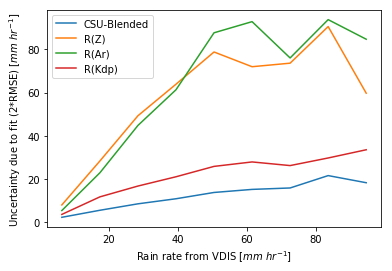

In [26]:
x_range = np.linspace(1, 100, 10)
rmse_rz = np.zeros(len(x_range)-1)
rmse_rar = np.zeros(len(x_range)-1)
rmse_rkdp = np.zeros(len(x_range)-1)
rmse_blended = np.zeros(len(x_range)-1)
x_bins = (x_range[1:]+x_range[:-1])/2

fig, ax = plt.subplots(1,1)
blended_rains = get_blended_rainfall(dsd_ds['Zh'].values, dsd_ds['Zdr'].values, dsd_ds['Kdp'].values)
rains_rz = 0.0192*(10**(dsd_ds['Zh'].values/10))**0.71
rains_rar = 297.87*((dsd_ds['Ai'].values))**0.92
rains_rkdp = 31.1840*((dsd_ds['Kdp'].values))**0.77
for which_hist in range(len(x_range)-1):
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, dsd_ds['rain_rate'].values >= x_range[which_hist],
                                      dsd_ds['rain_rate'].values < x_range[which_hist+1]))
    loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

    the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #31.1840*ds['kdp_dis']**0.77
    if(len(np.where(in_range)[0]) > 50):
        rmse_blended[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                                        blended_rains[in_range]))
        rmse_rz[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                                        rains_rz[in_range]))
        rmse_rar[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                                        rains_rar[in_range]))
        rmse_rkdp[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                                        rains_rkdp[in_range]))
    else:
        rmse_blended[which_hist] = np.nan
        rmse_rz[which_hist] = np.nan
        rmse_rar[which_hist] = np.nan
        rmse_rkdp[which_hist] = np.nan
        
ax.plot(x_bins, rmse_blended)
ax.plot(x_bins, rmse_rz)
ax.plot(x_bins, rmse_rar)
ax.plot(x_bins, rmse_rkdp)
ax.set_xlabel('Rain rate from VDIS [$mm\ hr^{-1}$]')
ax.legend(['CSU-Blended', 'R(Z)', 'R(Ar)', 'R(Kdp)'])
ax.set_ylabel('Uncertainty due to fit (2*RMSE) [$mm\ hr^{-1}$]')
print(rmse_blended)

0.5134381064582075 0.8194156460429245


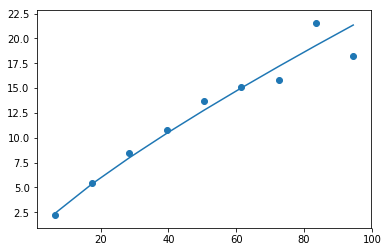

In [27]:
finite_ones = np.isfinite(rmse_blended)
RMSE_ab = np.polyfit(np.log10(x_bins), np.log10(rmse_blended[finite_ones]), 1)
RMSE_ab
b = RMSE_ab[0]
a = 10**RMSE_ab[1]
plt.plot(x_bins, a*x_bins**(b))
plt.scatter(x_bins, rmse_blended)
print(a,b)

/home/rjackson/.local/lib/python3.6/site-packages/csu_radartools/common.py:57: RuntimeWarning: invalid value encountered in power
  return a * kdp**b * 10.0**(c * zdr)
/home/rjackson/.local/lib/python3.6/site-packages/csu_radartools/common.py:74: RuntimeWarning: invalid value encountered in power
  return a * kdp**b
/home/rjackson/.local/lib/python3.6/site-packages/csu_radartools/csu_blended_rain_tropical.py:189: RuntimeWarning: invalid value encountered in greater_equal
  cond_zdr = zdr >= thresh_zdr
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/pyth

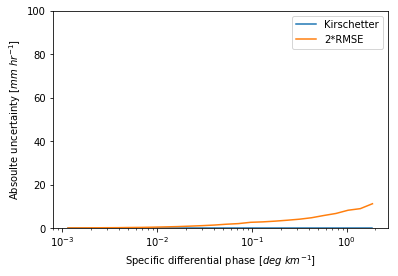

In [28]:
x_range = np.linspace(-3, 2, 40)
y_range = np.linspace(-1, 3, 40)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
uncertainty_z = np.zeros(len(x_range)-1)
rmse = np.zeros(len(x_range)-1)
fig, ax = plt.subplots(1,1)
blended_rains = get_blended_rainfall(dsd_ds['Zh'].values, dsd_ds['Zdr'].values, dsd_ds['Kdp'].values)
for which_hist in range(len(x_range)-1):
    hist_w_zeros = np.ma.filled(hist, 0)
    in_range = np.logical_and.reduce((gt0, np.log10(dsd_ds['Kdp'].values) >= x_range[which_hist],
                                      np.log10(dsd_ds['Kdp'].values) < x_range[which_hist+1]))
    loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

    the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #31.1840*ds['kdp_dis']**0.77
    if(len(np.where(in_range)[0]) > 500):
        rmse[which_hist] = 2*np.sqrt(mean_squared_error(dsd_ds['rain_rate'].values[in_range],
                                                        blended_rains[in_range]))
    else:
        uncertainty_z[which_hist] = np.nan
        rmse[which_hist] = np.nan



ax.plot(10**x_bins, uncertainty_z)
ax.plot(10**x_bins, rmse)
ax.set_xlabel('Specific differential phase [$deg\ km^{-1}$]')
ax.set_ylabel('Absoulte uncertainty [$mm\ hr^{-1}$]')
ax.set_xscale('log')
ax.set_ylim([0,100])
ax.legend(['Kirschetter', '2*RMSE'])

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-pack

(0, 2)

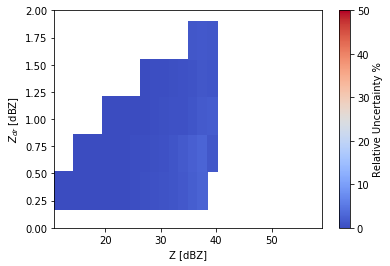

In [49]:
x_range = np.linspace(10, 60, 30)
zdr_range = np.linspace(0, 10, 30)
y_range = np.linspace(-1, 3, 30)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
zdr_bins = (zdr_range[1:]+zdr_range[:-1])/2
uncertainty_z_zdr_darwin = np.zeros((len(x_range)-1, len(zdr_range)-1))
mean_r_z_zdr_darwin = np.zeros_like(uncertainty_z_zdr)
fig, ax = plt.subplots(1,1)
for which_hist in range(len(x_range)-1):
    for which_hist2 in range(len(zdr_range)-1):
        hist_w_zeros = np.ma.filled(hist, 0)
        in_range = np.logical_and.reduce((gt0, dsd_ds['Zh'].values >= x_range[which_hist],
                                               dsd_ds['Zh'].values < x_range[which_hist+1],
                                               dsd_ds['Zdr'].values >= zdr_range[which_hist2],
                                               dsd_ds['Zdr'].values < zdr_range[which_hist2+1],
                                         ))
        loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

        the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
        quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])

        if(len(np.where(in_range)[0]) > 50):
            uncertainty_z_zdr_darwin[which_hist, which_hist2] = (10**quartiles[1]-10**quartiles[0])
            mean_r_z_zdr_darwin[which_hist, which_hist2]=10**loc_first
        else:
            uncertainty_z_zdr_darwin[which_hist, which_hist2] = np.nan
            mean_r_z_zdr_darwin[which_hist, which_hist2]=np.nan

uncertainty_z = np.ma.masked_where(np.isnan(uncertainty_z_zdr), uncertainty_z_zdr)
X, Y = np.meshgrid(x_bins, zdr_bins)
mesh = ax.pcolormesh(X, Y, uncertainty_z.T, cmap='coolwarm', vmin=0, vmax=50)
plt.colorbar(mesh, ax=ax, label='Relative Uncertainty %')
ax.set_xlabel('Z [dBZ]')
ax.set_ylabel('$Z_{dr}$ [dBZ]')
ax.set_ylim([0,2])

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel

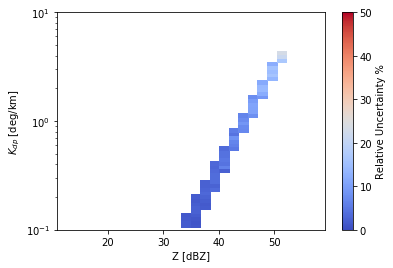

In [30]:
x_range = np.linspace(10, 60, 30)
zdr_range = np.logspace(-1, 1, 60)
y_range = np.linspace(-1, 3, 30)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
zdr_bins = (zdr_range[1:]+zdr_range[:-1])/2
uncertainty_z = np.zeros((len(x_range)-1, len(zdr_range)-1))
fig, ax = plt.subplots(1,1)
for which_hist in range(len(x_range)-1):
    for which_hist2 in range(len(zdr_range)-1):
        hist_w_zeros = np.ma.filled(hist, 0)
        in_range = np.logical_and.reduce((gt0, dsd_ds['Zh'].values >= x_range[which_hist],
                                               dsd_ds['Zh'].values < x_range[which_hist+1],
                                               dsd_ds['Kdp'].values >= zdr_range[which_hist2],
                                               dsd_ds['Kdp'].values < zdr_range[which_hist2+1],
                                         ))
        loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

        the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
        quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])

        if(len(np.where(in_range)[0]) > 50):
            uncertainty_z[which_hist, which_hist2] = (10**quartiles[1]-10**quartiles[0])
        else:
            uncertainty_z[which_hist, which_hist2] = np.nan

uncertainty_z = np.ma.masked_where(np.isnan(uncertainty_z), uncertainty_z)
X, Y = np.meshgrid(x_bins, zdr_bins)
mesh = ax.pcolormesh(X, Y, uncertainty_z.T, cmap='coolwarm', vmin=0, vmax=50)
plt.colorbar(mesh, ax=ax, label='Relative Uncertainty %')
ax.set_xlabel('Z [dBZ]')
ax.set_ylabel('$K_{dp}$ [deg/km]')
ax.set_ylim([1e-1,10])
ax.set_yscale('log')

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-pack

TypeError: Dimensions of C (59, 29) are incompatible with X (59) and/or Y (29); see help(pcolormesh)

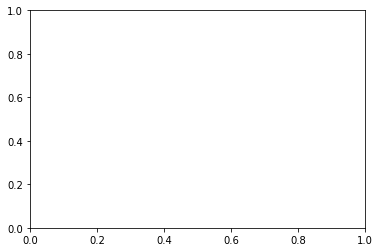

In [31]:
x_range = np.logspace(-1, 1, 60)
zdr_range = np.linspace(0, 10, 30)
y_range = np.linspace(-1, 3, 30)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
zdr_bins = (zdr_range[1:]+zdr_range[:-1])/2
uncertainty_kdp_zdr_darwin = np.zeros((len(x_range)-1, len(zdr_range)-1))
mean_rr_kdp_zdr_darwin = np.zeros_like(uncertainty_kdp_zdr_darwin)
fig, ax = plt.subplots(1,1)
for which_hist in range(len(x_range)-1):
    for which_hist2 in range(len(zdr_range)-1):
        hist_w_zeros = np.ma.filled(hist, 0)
        in_range = np.logical_and.reduce((gt0, dsd_ds['Kdp'].values >= x_range[which_hist],
                                               dsd_ds['Kdp'].values < x_range[which_hist+1],
                                               dsd_ds['Zdr'].values >= zdr_range[which_hist2],
                                               dsd_ds['Zdr'].values < zdr_range[which_hist2+1],
                                         ))
        loc_first = np.mean(np.log10(dsd_ds['rain_rate'].values[in_range]))

        the_fit = stats.norm.fit(np.log10(dsd_ds['rain_rate'].values[in_range]), loc=loc_first)
        quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])

        if(len(np.where(in_range)[0]) > 50):
            uncertainty_kdp_zdr_darwin[which_hist, which_hist2] = (10**quartiles[1]-10**quartiles[0])
            mean_rr_kdp_zdr_darwin[which_hist, which_hist2] = 10**loc_first
        else:
            uncertainty_kdp_zdr_darwin[which_hist, which_hist2] = np.nan
            mean_rr_kdp_zdr_darwin[which_hist, which_hist2] = np.nan
            
uncertainty_z = np.ma.masked_where(np.isnan(uncertainty_z), uncertainty_z)
X, Y = np.meshgrid(x_bins, zdr_bins)
mesh = ax.pcolormesh(X, Y, uncertainty_z.T, cmap='coolwarm', vmin=0, vmax=50)
plt.colorbar(mesh, ax=ax, label='Relative Uncertainty %')
ax.set_xlabel('$K_{dp}$ [deg/km]')
ax.set_ylabel('$Z_{dr}$ [dBZ]')
ax.set_ylim([1e-1,2])
ax.set_xscale('log')

## Manus Island uncertainty quantification @ C-band

In [32]:
import pandas as pd

In [33]:
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/MAN_Cband_good.out'
#    10.518     0.066     0.069     0.001  0.305E-03  0.306E-05  0.100E+01 -0.180E+03    -58.52      0.00
frame_man = pd.read_csv(data_path, header=None, names=["dBZ", "ZDR", "3", "KDP", "AHH", "6", "7", "8", "9", "10", "11"],
                   delim_whitespace=True)
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/GAN_Cband_good.out'
#    10.518     0.066     0.069     0.001  0.305E-03  0.306E-05  0.100E+01 -0.180E+03    -58.52      0.00
frame_gan = pd.read_csv(data_path, header=None, names=["dBZ", "ZDR", "3", "KDP", "AHH", "6", "7", "8", "9", "10", "11"],
                        delim_whitespace=True)
frame = pd.concat([frame_man, frame_gan])

In [34]:
frame.keys()

Index(['dBZ', 'ZDR', '3', 'KDP', 'AHH', '6', '7', '8', '9', '10', '11'], dtype='object')

In [35]:
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/MAN_dsd_good.out'
#    10.518     0.066     0.069     0.001  0.305E-03  0.306E-05  0.100E+01 -0.180E+03    -58.52      0.00
frame_psd_man = pd.read_csv(data_path, header=None, names=["Nw", "D0", "mu", "mu44"], delim_whitespace=True)
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/GAN_dsd_good.out'
#    10.518     0.066     0.069     0.001  0.305E-03  0.306E-05  0.100E+01 -0.180E+03    -58.52      0.00
frame_psd_gan = pd.read_csv(data_path, header=None, names=["Nw", "D0", "mu", "mu44"], delim_whitespace=True)
frame_psd = pd.concat([frame_psd_man, frame_psd_gan])

In [36]:
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/MAN_lwc_good.out'
#    10.518     0.066     0.069     0.001  0.305E-03  0.306E-05  0.100E+01 -0.180E+03    -58.52      0.00
frame_lwc_man = pd.read_csv(data_path, header=None, names=["time", "rr", "lwc", "dmax", "date", "date2"], delim_whitespace=True)
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/GAN_lwc_good.out'
#    10.518     0.066     0.069     0.001  0.305E-03  0.306E-05  0.100E+01 -0.180E+03    -58.52      0.00
frame_lwc_gan = pd.read_csv(data_path, header=None, names=["time", "rr", "lwc", "dmax", "date"], delim_whitespace=True)
frame_lwc = pd.concat([frame_lwc_man, frame_lwc_gan])
frame_lwc

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,date,date2,dmax,lwc,rr,time
0,20111202,20111202.0,0.85,0.000865,0.008739,231800
1,20111202,20111202.0,1.14,0.001328,0.018928,233100
2,20111204,20111204.0,1.39,0.022474,0.345161,191900
3,20111204,20111204.0,1.08,0.018307,0.255188,192000
4,20111204,20111204.0,1.04,0.028921,0.351934,192100
5,20111204,20111204.0,0.85,0.015428,0.143195,192200
6,20111204,20111204.0,2.52,0.048958,1.179445,212200
7,20111204,20111204.0,2.50,0.186836,4.009774,212300
8,20111204,20111204.0,1.78,0.151735,2.626106,212400
9,20111204,20111204.0,2.43,0.108225,1.737956,212500


In [37]:
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/MAN_other_good.out'
frame_other_man = pd.read_csv(data_path, header=None, names=["time", "num_drops", "3", "4", "5", "6", "7"], delim_whitespace=True)
data_path = '/lcrc/group/earthscience/rjackson/data/manus_dsds/GAN_other_good.out'
frame_other_gan = pd.read_csv(data_path, header=None, names=["time", "num_drops", "3", "4", "5", "6", "7"], delim_whitespace=True)
frame_other = pd.concat([frame_other_man, frame_other_gan])

In [38]:
plt.scatter(frame["ZDR"].values[do_rz], frame_lwc["rr"].values[do_rz])
plt.xlim([0,10])
plt.ylim([0,100])

NameError: name 'do_rz' is not defined

In [39]:
good_filter = np.logical_and(frame_other["num_drops"] > 100, frame_lwc["rr"] > 0.05)
kdp_gt03 = np.logical_and(good_filter, frame["KDP"] > 0.3)
kdp_lt03 = np.logical_and(good_filter, frame["KDP"] <= 0.3)
do_rz = np.logical_and(kdp_lt03, frame["ZDR"] < 0.25)
do_rz_zdr = np.logical_and(kdp_lt03, frame["ZDR"] > 0.25)
do_r_kdp = np.logical_and(kdp_gt03, frame["ZDR"] < 0.25)
do_r_kdp_zdr = np.logical_and(kdp_gt03, frame["ZDR"] > 0.25)
convective = np.log10(frame_psd["Nw"]) > 3.85
stratiform = ~convective
do_rz_convective = np.logical_and(convective, do_rz)
do_rz_stratiform = np.logical_and(stratiform, do_rz)

# PDFs for each different regime

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


Text(0.5,0,'Rainfall rate [mm/hr]')

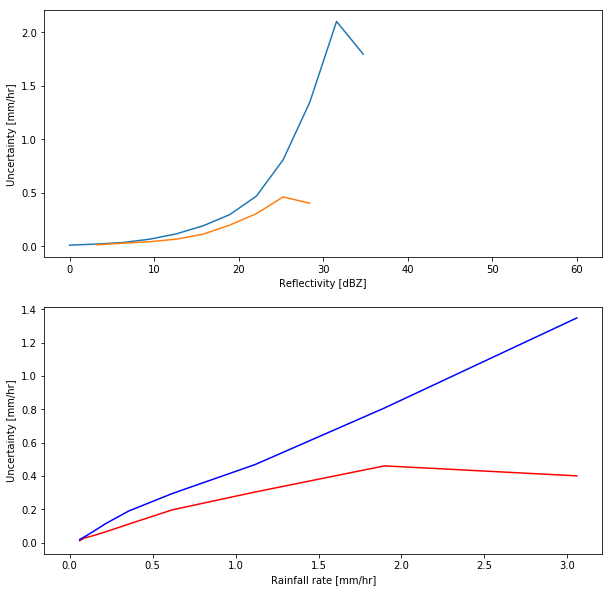

In [40]:
# Z convective
z_bins = np.linspace(0, 60, 20)
uncertainty_z_convective = np.zeros_like(z_bins)
uncertainty_z_stratiform = np.zeros_like(z_bins)
mean_rr_z_convective = np.zeros_like(z_bins)
mean_rr_z_stratiform = np.zeros_like(z_bins)

for i in range(len(z_bins)-1):
    which_hist = i
    in_range = np.logical_and.reduce((frame["dBZ"] >= z_bins[i],
                                      frame["dBZ"] < z_bins[i+1],
                                      do_rz_convective))
    loc_first = np.nanmean(np.log10(frame_lwc["rr"].values[in_range]))
    the_fit = stats.norm.fit(np.log10(frame_lwc["rr"].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #31.1840*ds['kdp_dis']**0.77
    if(len(np.where(in_range)[0]) > 1):
        uncertainty_z_convective[which_hist] = (10**quartiles[1]-10**quartiles[0])
        mean_rr_z_convective[which_hist] = 10**loc_first 
    else:
        uncertainty_z_convective[which_hist] = np.nan
        mean_rr_z_stratiform[which_hist] = np.nan
    
    in_range = np.logical_and.reduce((frame["dBZ"] >= z_bins[i],
                                      frame["dBZ"] < z_bins[i+1],
                                      do_rz_stratiform))
    loc_first = np.nanmean(np.log10(frame_lwc["rr"].values[in_range]))
    the_fit = stats.norm.fit(np.log10(frame_lwc["rr"].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #31.1840*ds['kdp_dis']**0.77
    if(len(np.where(in_range)[0]) > 1):
        uncertainty_z_stratiform[which_hist] = (10**quartiles[1]-10**quartiles[0])
        mean_rr_z_stratiform[which_hist] = 10**loc_first
    else:
        uncertainty_z_stratiform[which_hist] = np.nan
        mean_rr_z_stratiform[which_hist] = np.nan

fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(z_bins, uncertainty_z_convective)
ax[0].plot(z_bins, uncertainty_z_stratiform)
ax[0].set_xlabel("Reflectivity [dBZ]")
ax[0].set_ylabel("Uncertainty [mm/hr]")
ax[1].plot(mean_rr_z_stratiform, uncertainty_z_stratiform, color='r')
ax[1].plot(mean_rr_z_stratiform, uncertainty_z_convective, color='b')
ax[1].set_ylabel("Uncertainty [mm/hr]")
ax[1].set_xlabel("Rainfall rate [mm/hr]")

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/blues/gpfs/home/rjackson/anaconda3/envs/yt_de

TypeError: Dimensions of C (59, 29) are incompatible with X (29) and/or Y (29); see help(pcolormesh)

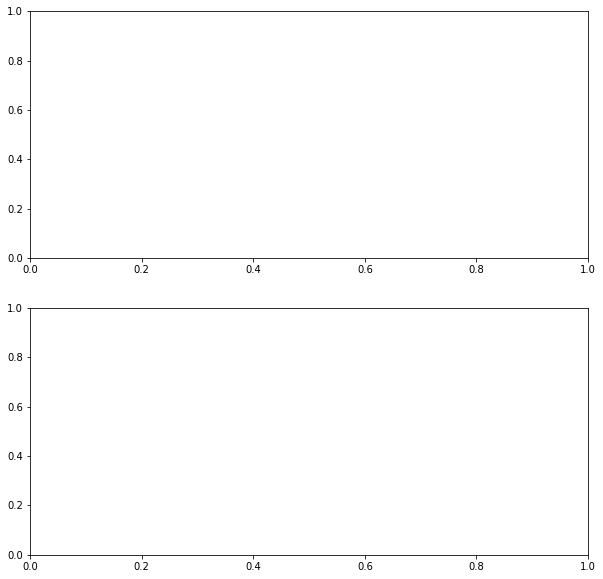

In [42]:
x_range = np.linspace(10, 60, 30)
zdr_range = np.linspace(0, 10, 30)
y_range = np.linspace(-1, 3, 30)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
zdr_bins = (zdr_range[1:]+zdr_range[:-1])/2
uncertainty_z_zdr = np.zeros((len(x_range)-1, len(zdr_range)-1))
mean_rr_z_zdr = np.zeros_like(uncertainty_z_zdr)

for which_hist in range(len(x_range)-1):
    for which_hist2 in range(len(zdr_range)-1):
        hist_w_zeros = np.ma.filled(hist, 0)
        in_range = np.logical_and.reduce((do_rz_zdr, frame["dBZ"].values >= x_range[which_hist],
                                                     frame["dBZ"].values < x_range[which_hist+1],
                                                     frame["ZDR"].values >= zdr_range[which_hist2],
                                                     frame['ZDR'].values < zdr_range[which_hist2+1],
                                         ))
        loc_first = np.mean(np.log10(frame_lwc["rr"].values[in_range]))

        the_fit = stats.norm.fit(np.log10(frame_lwc["rr"].values[in_range]), loc=loc_first)
        quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])

        if(len(np.where(in_range)[0]) > 5):
            uncertainty_z_zdr[which_hist, which_hist2] = (10**quartiles[1]-10**quartiles[0])
            mean_rr_z_zdr[which_hist, which_hist2] = 10**loc_first
        else:
            uncertainty_z_zdr[which_hist, which_hist2] = np.nan
            mean_rr_z_zdr[which_hist, which_hist2] = np.nan

fig, ax = plt.subplots(2,1,figsize=(10,10))
uncertainty_z = np.ma.masked_where(np.isnan(uncertainty_z), uncertainty_z)
X, Y = np.meshgrid(x_bins, zdr_bins)
mesh = ax[0].pcolormesh(X, Y, uncertainty_z.T, cmap='coolwarm', vmin=0, vmax=0.5)
plt.colorbar(mesh, ax=ax[0], label='Absolute Uncertainty [mm/hr]')
ax[0].set_xlabel('Z [dBZ]')
ax[0].set_ylabel('$Z_{dr}$ [dBZ]')
ax[0].set_ylim([0,2])
ax[1].scatter(mean_rr_z_zdr, uncertainty_z_zdr)
ax[1].set_xlabel("Rainfall rate [mm/hr]")
ax[1].set_ylabel("Uncertainty [mm/hr]")

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


NameError: name 'mean_rr_kdp' is not defined

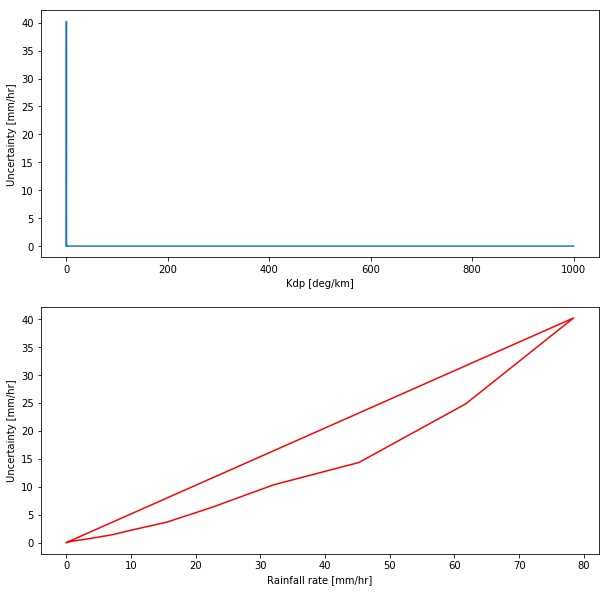

In [44]:
# Z convective
kdp = np.logspace(-4,3,40)
uncertainty_ar_man = np.zeros_like(kdp)
mean_rr_ar_man = np.zeros_like(kdp)

for i in range(len(z_bins)-1):
    which_hist = i
    in_range = np.logical_and.reduce((frame["AHH"] >= kdp[i],
                                      frame["AHH"] < kdp[i+1],
                                      good_filter))
    print(len(np.where(do_r_kdp)[0]))
    loc_first = np.nanmean(np.log10(frame_lwc["rr"].values[in_range]))
    the_fit = stats.norm.fit(np.log10(frame_lwc["rr"].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #31.1840*ds['kdp_dis']**0.77
    if(len(np.where(in_range)[0]) > 1):
        uncertainty_ar_man[which_hist] = (10**quartiles[1]-10**quartiles[0])
        mean_rr_ar_man[which_hist] = 10**loc_first 
    else:
        uncertainty_ar_man[which_hist] = np.nan
        mean_rr_ar_man[which_hist] = np.nan
    
    
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(kdp, uncertainty_ar_man)
ax[0].set_xlabel("Kdp [deg/km]")
ax[0].set_ylabel("Uncertainty [mm/hr]")
ax[1].plot(mean_rr_ar_man, uncertainty_ar_man, color='r')
ax[1].set_ylabel("Uncertainty [mm/hr]")
ax[1].set_xlabel("Rainfall rate [mm/hr]")
print(mean_rr_kdp)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


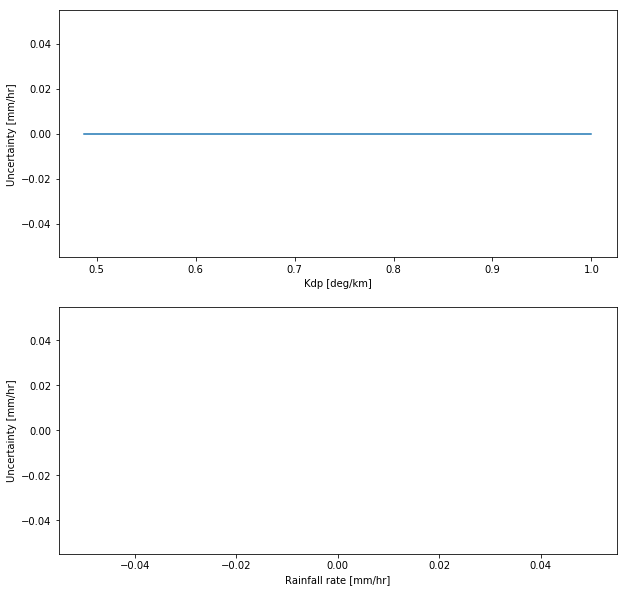

In [45]:
# Z convective
kdp = np.linspace(0, 1, 40)
uncertainty_kdp = np.zeros_like(kdp)
mean_rr_kdp = np.zeros_like(kdp)

for i in range(len(z_bins)-1):
    which_hist = i
    in_range = np.logical_and.reduce((frame["KDP"] >= kdp[i],
                                      frame["KDP"] < kdp[i+1],
                                      do_r_kdp))
    print(len(np.where(do_r_kdp)[0]))
    loc_first = np.nanmean(np.log10(frame_lwc["rr"].values[in_range]))
    the_fit = stats.norm.fit(np.log10(frame_lwc["rr"].values[in_range]), loc=loc_first)
    quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])
    #31.1840*ds['kdp_dis']**0.77
    if(len(np.where(in_range)[0]) > 1):
        uncertainty_kdp[which_hist] = (10**quartiles[1]-10**quartiles[0])
        mean_rr_kdp[which_hist] = 10**loc_first 
    else:
        uncertainty_kdp[which_hist] = np.nan
        mean_rr_kdp[which_hist] = np.nan
    
    
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(kdp, uncertainty_kdp)
ax[0].set_xlabel("Kdp [deg/km]")
ax[0].set_ylabel("Uncertainty [mm/hr]")
ax[1].plot(mean_rr_kdp, uncertainty_kdp, color='r')
ax[1].set_ylabel("Uncertainty [mm/hr]")
ax[1].set_xlabel("Rainfall rate [mm/hr]")
print(mean_rr_kdp)

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/blues/gpfs/home/rjackson/anaconda3/envs/yt_de

Text(0,0.5,'Uncertainty [mm/hr]')

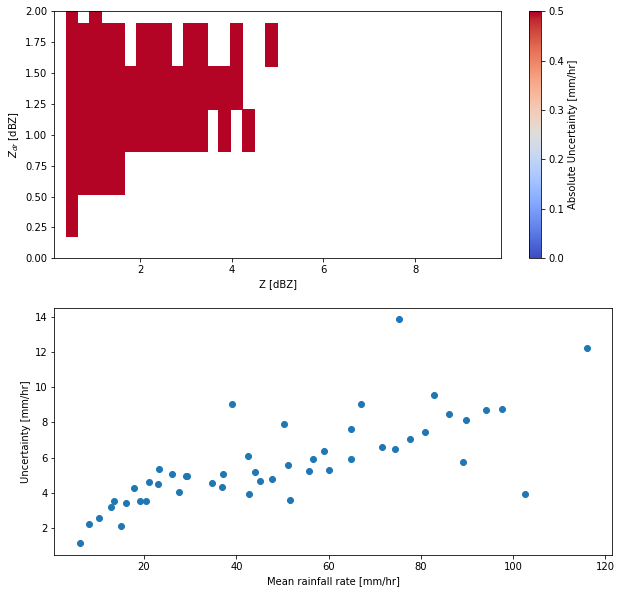

In [47]:
x_range = np.linspace(0, 10, 40)
zdr_range = np.linspace(0, 10, 30)
y_range = np.linspace(-1, 3, 30)
y_bins = (y_range[1:]+y_range[:-1])/2
x_bins = (x_range[1:]+x_range[:-1])/2
zdr_bins = (zdr_range[1:]+zdr_range[:-1])/2
uncertainty_kdp_zdr = np.zeros((len(x_range)-1, len(zdr_range)-1))
mean_rr_kdp_zdr = np.zeros_like(uncertainty_kdp_zdr)

for which_hist in range(len(x_range)-1):
    for which_hist2 in range(len(zdr_range)-1):
        hist_w_zeros = np.ma.filled(hist, 0)
        in_range = np.logical_and.reduce((do_r_kdp_zdr, frame["KDP"].values >= x_range[which_hist],
                                                     frame["KDP"].values < x_range[which_hist+1],
                                                     frame["ZDR"].values >= zdr_range[which_hist2],
                                                     frame['ZDR'].values < zdr_range[which_hist2+1],
                                         ))
        loc_first = np.mean(np.log10(frame_lwc["rr"].values[in_range]))

        the_fit = stats.norm.fit(np.log10(frame_lwc["rr"].values[in_range]), loc=loc_first)
        quartiles = stats.norm.interval(0.5, loc=the_fit[0], scale=the_fit[1])

        if(len(np.where(in_range)[0]) > 5):
            uncertainty_kdp_zdr[which_hist, which_hist2] = (10**quartiles[1]-10**quartiles[0])
            mean_rr_kdp_zdr[which_hist, which_hist2] = 10**loc_first
        else:
            uncertainty_kdp_zdr[which_hist, which_hist2] = np.nan
            mean_rr_kdp_zdr[which_hist, which_hist2] = np.nan

fig, ax = plt.subplots(2,1,figsize=(10,10))
uncertainty_z = np.ma.masked_where(np.isnan(uncertainty_kdp_zdr), uncertainty_kdp_zdr)
X, Y = np.meshgrid(x_bins, zdr_bins)
mesh = ax[0].pcolormesh(X, Y, uncertainty_z.T, cmap='coolwarm', vmin=0, vmax=0.5)
plt.colorbar(mesh, ax=ax[0], label='Absolute Uncertainty [mm/hr]')
ax[0].set_xlabel('Z [dBZ]')
ax[0].set_ylabel('$Z_{dr}$ [dBZ]')
ax[0].set_ylim([0,2])
ax[1].scatter(mean_rr_kdp_zdr, uncertainty_kdp_zdr)
ax[1].set_xlabel("Mean rainfall rate [mm/hr]")
ax[1].set_ylabel("Uncertainty [mm/hr]")

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


(0.1, 100)

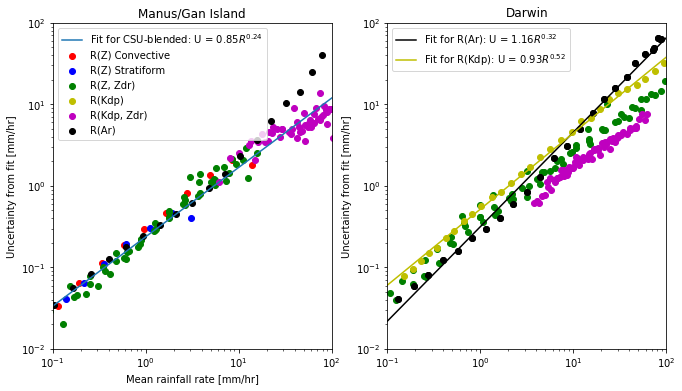

In [50]:
fig, ax = plt.subplots(1,2, figsize=(11,6))
ax[0].scatter(mean_rr_z_convective, uncertainty_z_convective, color='r', label="R(Z) Convective")
ax[0].scatter(mean_rr_z_stratiform, uncertainty_z_stratiform, color='b', label="R(Z) Stratiform")
ax[0].scatter(mean_rr_z_zdr, uncertainty_z_zdr, color='g', label="R(Z, Zdr)")
ax[0].scatter(mean_rr_kdp, uncertainty_kdp, color='y', label="R(Kdp)")
ax[0].scatter(mean_rr_kdp_zdr, uncertainty_kdp_zdr, color='m', label="R(Kdp, Zdr)")
ax[0].scatter(mean_rr_ar_man, uncertainty_ar_man, color='k', label="R(Ar)")
ax[1].scatter(mean_rr_ar_darwin, uncertainty_ar_darwin, color='k')
ax[1].scatter(mean_r_z_zdr_darwin, uncertainty_z_zdr_darwin, color='g')
ax[1].scatter(mean_rr_kdp_darwin, uncertainty_kdp_darwin, color='y')
ax[1].scatter(mean_rr_kdp_zdr_darwin, uncertainty_kdp_zdr_darwin, color='m')
ax[1].scatter(mean_rr_ar_darwin, uncertainty_ar_darwin, color='k', )
ax[0].set_xlabel("Mean rainfall rate [mm/hr]")
ax[0].set_ylabel("Uncertainty from fit [mm/hr]")
ax[1].set_ylabel("Uncertainty from fit [mm/hr]")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

mean_rr = np.concatenate([mean_rr_z_convective.flatten(), mean_rr_z_stratiform.flatten(), 
                          mean_rr_z_zdr.flatten(), mean_rr_kdp.flatten(), mean_rr_kdp_zdr.flatten()])
uncertainty = np.concatenate([uncertainty_z_convective.flatten(), uncertainty_z_stratiform.flatten(), 
                              uncertainty_z_zdr.flatten(), uncertainty_kdp.flatten(), uncertainty_kdp_zdr.flatten()])
inds = np.logical_and(np.isfinite(np.log10(mean_rr)), np.isfinite(np.log10(uncertainty)))
fit = np.polyfit(np.log10(mean_rr[inds]), np.log10(uncertainty[inds]), 1)
x_range = np.logspace(-1, 2.5, 50)
a = fit[0]
b = 10**fit[1]
ax[0].plot(x_range, 10**np.polyval(fit, np.log10(x_range)), label=('Fit for CSU-blended: U = ' + "%04.2f" % a + '$R^{' + "%04.2f" % b + '}$'))


inds = np.logical_and(np.isfinite(np.log10(mean_rr_ar_darwin)), np.isfinite(np.log10(uncertainty_ar_darwin)))
fit = np.polyfit(np.log10(mean_rr_ar_darwin[inds]), np.log10(uncertainty_ar_darwin[inds]), 1)
x_range = np.logspace(-1, 2.5, 50)
a = fit[0]
b = 10**fit[1]
ax[1].plot(x_range, 10**np.polyval(fit, np.log10(x_range)), 
        label=('Fit for R(Ar): U = ' + "%04.2f" % a + '$R^{' + "%04.2f" % b + '}$'),
        color='k')
inds = np.logical_and(np.isfinite(np.log10(mean_rr_kdp_darwin)), np.isfinite(np.log10(uncertainty_kdp_darwin)))
fit = np.polyfit(np.log10(mean_rr_kdp_darwin[inds]), np.log10(uncertainty_kdp_darwin[inds]), 1)
x_range = np.logspace(-1, 2.5, 50)
a = fit[0]
b = 10**fit[1]
ax[1].plot(x_range, 10**np.polyval(fit, np.log10(x_range)), 
        label=('Fit for R(Kdp): U = ' + "%04.2f" % a + '$R^{' + "%04.2f" % b + '}$'),
        color='y')
ax[1].legend()
ax[0].legend()
ax[0].set_title('Manus/Gan Island')
ax[1].set_title('Darwin')
ax[0].set_ylim([0.01, 100])
ax[1].set_ylim([0.01, 100])
ax[0].set_xlim([0.1, 100])
ax[1].set_xlim([0.1, 100])
# log y = a*log x + b
# y = 10**(a*log x) * 10**b
# y = 10**(log x)**a * B
# y = x**a * 10**b
# y = 10**b(x**a)